# The Adiabatic Rapid Passage Map for Rydberg Atoms
In this document, we produce a map for the adiabatic rapid passage for Rydberg atoms. We first calculated the energy shifts(DC stark shifts) of different m states of the same l and n under a static electric field and the dipolar coupling between two neighbouring states (We ignore coupling between states that are not neighbouring). And then we construct the Hamiltonian through which we can diaganlise and calculate the 'dressed state' eigenvalues.

In [1]:
# Import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from arc import *
# https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/installation.html
import scipy.constants as cts
from numpy.linalg import eig

In [2]:
# Some experimental parameters and constants
# Physical constants
a0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
h = cts.h  # Planck's constant in J*s
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second

## Calculate the dipole matrix elements between states in static electric field.
We calculate the dipole matrix elements and the energy by diagonalising the stark hamiltonian. We use an adiabatic approach to track the state, that is, we always follow the state with the largest overlap with the previous state.

In [3]:
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import sys



class MatrixElementsEfield:
    def __init__(self, StarkMap1, StarkMap2, progressOutput=False):
        """
        calculates dipolar coupling between the two original target states
        of the two Stark Maps

        Note:
            StarkMaps have to have **defined basis**
            AND
            StarkMaps have to be calculated **for the same atom**
        """
        # save pointers to Stark maps for later
        self.StarkMap1 = StarkMap1
        self.StarkMap2 = StarkMap2

        # construct and save CSV sparce matrix of couplings
        matrixDMEcoupling = [[], [], []]

        for i in range(len(StarkMap1.basisStates)):
            if progressOutput:
                sys.stdout.write(
                    "\r%d%%"
                    % (float(i) / float(len(StarkMap1.basisStates) - 1) * 100)
                )
                sys.stdout.flush()
            for j in range(len(StarkMap2.basisStates)):
                # if dipole coupled, add to coupling
                dl = abs(
                    StarkMap1.basisStates[i][1] - StarkMap2.basisStates[j][1]
                )
                dj = abs(
                    StarkMap1.basisStates[i][2] - StarkMap2.basisStates[j][2]
                )
                if dl == 1 and (dj < 1.1):
                    dme = StarkMap1.atom.getDipoleMatrixElement(
                        StarkMap1.basisStates[i][0],
                        StarkMap1.basisStates[i][1],
                        StarkMap1.basisStates[i][2],
                        StarkMap1.basisStates[i][3],
                        StarkMap2.basisStates[j][0],
                        StarkMap2.basisStates[j][1],
                        StarkMap2.basisStates[j][2],
                        StarkMap2.basisStates[j][3],
                        q,
                    )
                    matrixDMEcoupling[0].append(dme)
                    matrixDMEcoupling[1].append(i)
                    matrixDMEcoupling[2].append(j)

        self.matrixDMEcoupling = csr_matrix(
            (
                matrixDMEcoupling[0],
                (matrixDMEcoupling[1], matrixDMEcoupling[2]),
            ),
            shape=(len(StarkMap1.basisStates), len(StarkMap2.basisStates)),
        )

        
    def getDipolarCoupling(self, initialeFieldList, initialStep=0,tolerance=5):
        """
        Arguments:
            eFieldMin, eFieldMax : float
                The minimum and maximum electric fields for which you want to calculate the couplings
            initialStep : float
                The initial step size for eField
            tolerance : float
                The tolerance for coupling difference between two points. If the difference is larger, we reduce the step size.
        """
        
        #self.StarkMap1.diagonalise(initialeFieldList)
        #self.StarkMap2.diagonalise(initialeFieldList)

        # find initial states
        initalState1 = np.zeros(len(self.StarkMap1.basisStates))   
        initalState1[self.StarkMap1.indexOfCoupledState] = 1
        initalState2 = np.zeros(len(self.StarkMap2.basisStates))
        initalState2[self.StarkMap2.indexOfCoupledState] = 1
        
        
        
        
        eFieldMin = np.min(initialeFieldList)
        eFieldMax = np.max(initialeFieldList)

        if initialStep == 0:
            initialStep = (eFieldMax - eFieldMin) / len(initialeFieldList)
        
        eFieldList = []
        eField = eFieldMin

            
        couplingList, transitionFrequency, energy1List, energy2List = [], [], [], []
        prevCoupling = None
        
        while eField <= eFieldMax:
            # Your existing code to calculate `coupling`, `energy1`, `energy2` here...
            # ...
                        # find first state in electric field
            m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
            # diagonalise the matrices
            ev1, egvector1 = eigh(m1)

            m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
            ev2, egvector2 = eigh(m2)

            # ----------------------Track the state ----------------------
            # find state that has largest overlap to the selected state for 
            # previous value of eField, starting with the initial state for zero field
            # i.e. it is adiabatically connected to the initial state

            maxOverlap1 = 0  # overlap with previous selected state
            eigenvectorIndex1 = 0
            for i in range(len(ev1)):
                if ( abs(np.vdot(egvector1[:, i], initalState1)) > maxOverlap1 ):
                    maxOverlap1 = abs(np.vdot(egvector1[:, i], initalState1))
                    eigenvectorIndex1= i

            # save reference point for search of closest state for higher eField in next step
            
            initalState1 = egvector1[:, eigenvectorIndex1] 

            energy1 = ev1[eigenvectorIndex1]
            state1composition = egvector1[:, eigenvectorIndex1]

            # Do the same thing for the second Stark map
            maxOverlap2 = 0
            eigenvectorIndex2 = 0
            for i in range(len(ev2)):
                if ( abs(np.vdot(egvector2[:, i], initalState2)) > maxOverlap2 ):
                    maxOverlap2 = abs(np.vdot(egvector2[:, i], initalState2))
                    eigenvectorIndex2= i
            
            initalState2 = egvector2[:, eigenvectorIndex2]
            energy2 = ev2[eigenvectorIndex2]
            state2composition = egvector2[:, eigenvectorIndex2]

            # ----------------------Calculate the coupling ----------------------
            
            # find coupling between the states

            coupling = self.matrixDMEcoupling.dot(state2composition).dot(
                state1composition
            )
            eFieldList.append(eField)
            if prevCoupling is not None:
                couplingDifference = coupling - prevCoupling
                if couplingDifference <0:
                    # Re-adjust eField list to add more points around this region
                    eFieldList.remove(eField)
                    initialStep = initialStep / 2
                    eField = eField - initialStep
                    #eFieldList.sort()  # Make sure the list is sorted for next iterations
                elif couplingDifference < tolerance / 2 and eField + initialStep*2 < eFieldMax:
                    initialStep = initialStep * 2
                    
                    eField += initialStep
                    prevCoupling = coupling
                    couplingList.append(np.abs(coupling))
                elif eField + initialStep > eFieldMax and eField < eFieldMax:
                    eField = eFieldMax
                    prevCoupling = coupling
                    couplingList.append(np.abs(coupling))
                else:
                    eField += initialStep
                    prevCoupling = coupling
                    couplingList.append(np.abs(coupling))
            else:
                eField += initialStep
                prevCoupling = coupling
                couplingList.append(np.abs(coupling))
            
        
            energy1List.append(energy1)
            energy2List.append(energy2)
        
        couplingList = np.array(couplingList) # in the unit of a0e
        energy1List = -1*np.array(energy1List) # in the unit of GHz, negative sign because it is ionisation energy
        energy2List = -1*np.array(energy2List) # in the unit of GHz
        transitionFrequency = np.abs(energy2List - energy1List) # in the unit of GHz    

        # ... rest of your code to process couplingList, energy1List, and energy2List

        return couplingList, transitionFrequency, energy1List, energy2List, eFieldList
    
   
    def getDipolarCoupling2(self, eFieldList):
        """
        find dipolar coupling and transition frequency between target states and energy shifts of two states

        Target states are specified during the initialization procedure of the StarkMap1 and StarkMap2
        """
        self.StarkMap1.diagonalise(eFieldList)
        self.StarkMap2.diagonalise(eFieldList)

        # find initial states
        initalState1 = np.zeros(len(self.StarkMap1.basisStates))   
        initalState1[self.StarkMap1.indexOfCoupledState] = 1
        initalState2 = np.zeros(len(self.StarkMap2.basisStates))
        initalState2[self.StarkMap2.indexOfCoupledState] = 1
        
        # Coupling and energy lists
        couplingList = []
        energy1List = []
        energy2List = []

        for eField in eFieldList:
            # find first state in electric field
            m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
            # diagonalise the matrices
            ev1, egvector1 = eigh(m1)

            m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
            ev2, egvector2 = eigh(m2)

            # ----------------------Track the state ----------------------
            # find state that has largest overlap to the selected state for 
            # previous value of eField, starting with the initial state for zero field
            # i.e. it is adiabatically connected to the initial state

            maxOverlap1 = 0  # overlap with previous selected state
            eigenvectorIndex1 = 0
            for i in range(len(ev1)):
                if ( abs(np.vdot(egvector1[:, i], initalState1)) > maxOverlap1 ):
                    maxOverlap1 = abs(np.vdot(egvector1[:, i], initalState1))
                    eigenvectorIndex1= i

            # save reference point for search of closest state for higher eField in next step
            
            initalState1 = egvector1[:, eigenvectorIndex1] 

            energy1 = ev1[eigenvectorIndex1]
            state1composition = egvector1[:, eigenvectorIndex1]

            # Do the same thing for the second Stark map
            maxOverlap2 = 0
            eigenvectorIndex2 = 0
            for i in range(len(ev2)):
                if ( abs(np.vdot(egvector2[:, i], initalState2)) > maxOverlap2 ):
                    maxOverlap2 = abs(np.vdot(egvector2[:, i], initalState2))
                    eigenvectorIndex2= i
            
            initalState2 = egvector2[:, eigenvectorIndex2]
            energy2 = ev2[eigenvectorIndex2]
            state2composition = egvector2[:, eigenvectorIndex2]

            # ----------------------Calculate the coupling ----------------------
            
            # find coupling between the states

            coupling = self.matrixDMEcoupling.dot(state2composition).dot(
                state1composition
            )

            couplingList.append(np.abs(coupling))
            energy1List.append(energy1)
            energy2List.append(energy2)
        
        couplingList = np.array(couplingList) # in the unit of a0e
        energy1List = -1*np.array(energy1List) # in the unit of GHz, negative sign because it is ionisation energy
        energy2List = -1*np.array(energy2List) # in the unit of GHz
        transitionFrequency = np.abs(energy2List - energy1List) # in the unit of GHz
        
        # Note energy1List and energy2List are ionisation energy so should be negative
        return couplingList, transitionFrequency, energy1List, energy2List
 


## Test the dipole matrix element Calculation using Rubidium n=20, l0=19, mj1=0.5, mj2 = 1.5

In [4]:
# Create the Stark maps for two states
atom = Rubidium87()
n0 = 30
l0 = n0-1
j0 = l0+0.5
mj01 = 9.5
mj02 = 10.5
q=1
# usually deltaN above 3 gives good results but may depends
deltaN = 5 
maxL = n0-1


stMap1 = StarkMap(atom)
stMap1.defineBasis(
    n0, l0, j0, mj01, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
)

stMap2 = StarkMap(atom)
stMap2.defineBasis(
    n0, l0, j0, mj02, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
)



0

In [13]:
# Get the coupling and transition frequency
eFieldList = np.linspace(0, 0.5, 400)

calc = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)
c, f, e1, e2  = calc.getDipolarCoupling2(eFieldList)

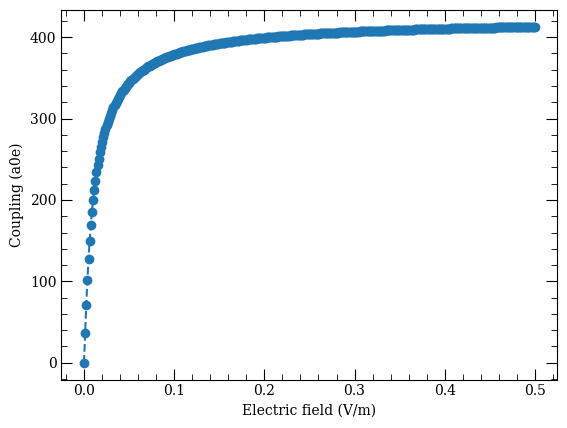

In [87]:
# Plot the coupling
plt.plot(eFieldList, c, "o--")
plt.xlabel("Electric field (V/m)")
plt.ylabel("Coupling (a0e)")
plt.show()

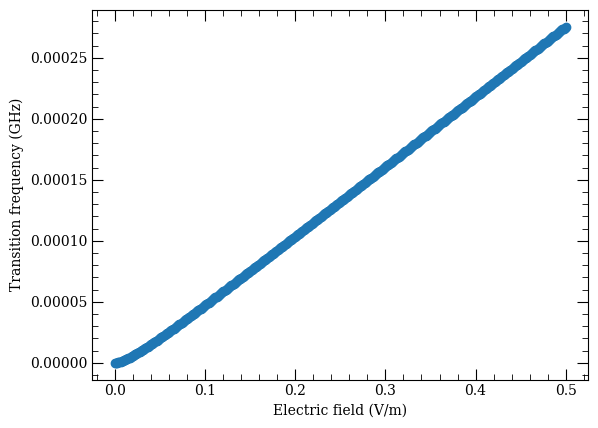

In [88]:
# Plot the transition frequency
plt.plot(eFieldList, f, "o--")
plt.xlabel("Electric field (V/m)")
plt.ylabel("Transition frequency (GHz)")
plt.show()

In [1]:
# Plot the energy shifts of the two states
energyOfOriginalState = -(
atom.getEnergy(n0, l0, j0) * e / h * 1e-9)  # in GHz, negative sign because it is ionisation energy

e1Shift = e1 - energyOfOriginalState
e2Shift = e2 - energyOfOriginalState

plt.plot(eFieldList, e1Shift, "--", label="State 1")
plt.plot(eFieldList, e2Shift, "--", label="State 2")
plt.xlabel("Electric field (V/m)")
plt.ylabel("Energy shift (GHz)")
plt.legend()
plt.show()

NameError: name 'atom' is not defined

## Calculate the energy shift and dipole coupling for states in static electric field.

In [90]:
# Calculate the dipole matrix elements and energy shifts between different states

atom = Rubidium()
eFieldList1 = np.linspace(0, 3, 400)
eFieldList2=np.linspace(3,500,50) # electric field list in V/m
eFieldList = np.concatenate((eFieldList1, eFieldList2), axis=None)

n0 = 30 # principal quantum number

l0 = n0-1 # orbital angular momentum
j0 = l0+0.5 # total angular momentum
deltaN = 3 # deltaN
maxL = n0-1 # maximum value of l to include
q=1 # sigma+ transition
mj0s = np.arange(0.5, j0, 1) # mj0s to include

dipoleMatrixElements = []
# list of dipole matrix elements for different mj0s
transitionFrequencies = []
energyShifts = []
# list of energy shifts for different mj0s

for mj0 in mj0s:
    
    stMap1 = StarkMap(atom)
    stMap1.defineBasis(
        n0, l0, j0, mj0, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
    )
    stMap2 = StarkMap(atom)
    stMap2.defineBasis(
        n0, l0, j0, mj0+1, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
    )


    calc = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)

    couplingList, frequencyList, energy1s, energy2s = calc.getDipolarCoupling2(eFieldList)
    
    energyOfOriginalState = -(
    atom.getEnergy(n0, l0, j0) * e / h * 1e-9) # original energy in GHz
    
    dipoleMatrixElements.append(couplingList)
    energyShifts.append(energy1s-energyOfOriginalState)
    transitionFrequencies.append(frequencyList)
    if mj0 == j0-1:
        # include the last state
        energyShifts.append(energy2s-energyOfOriginalState)

dipoleMatrixElements = np.array(dipoleMatrixElements) # dipoleMatrixElements has mj0s elements
transitionFrequencies = np.array(transitionFrequencies) # transitionFrequencies has mj0s elements
energyShifts = np.array(energyShifts) # energyShifts has mj0s+1 elements
    


In [68]:
# Save the dme and energy shifts
np.savez('data/coupling_energy30.npz', n0, mj0s, eFieldList, dipoleMatrixElements, energyShifts, transitionFrequencies,
         n0=n0, mj0s=mj0s, eFieldList=eFieldList, dipoleMatrixElements=dipoleMatrixElements, energyShifts=energyShifts, transitionFrequencies=transitionFrequencies)
        

In [5]:
# Load the dme and energy shifts
fileName = 'data/coupling_energy30.npz'
n0 = np.load(fileName)['n0']
mj0s = np.load(fileName)['mj0s']
eFieldList = np.load(fileName)['eFieldList']
dipoleMatrixElements = np.load(fileName)['dipoleMatrixElements']
energyShifts = np.load(fileName)['energyShifts']
transitionFrequencies = np.load(fileName)['transitionFrequencies']


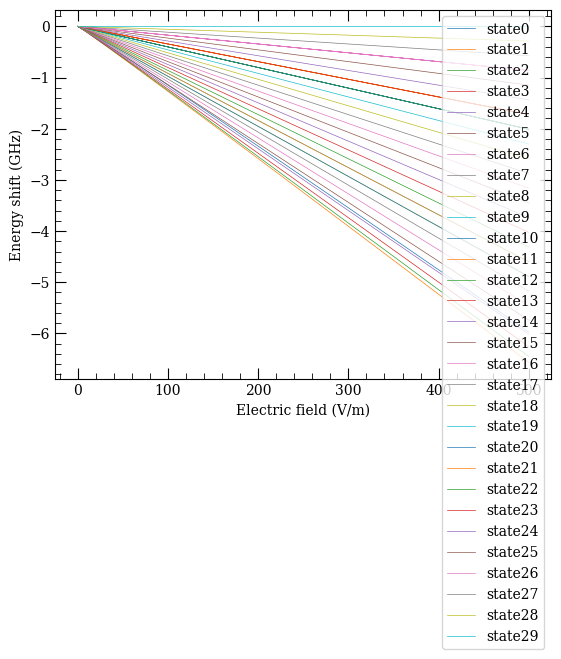

In [17]:
# plot the energy shifts
for n in range(30):
    plt.plot(eFieldList,energyShifts[n],label = 'state'+str(n), linewidth=0.5)
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy shift (GHz)')
plt.legend()
plt.show()

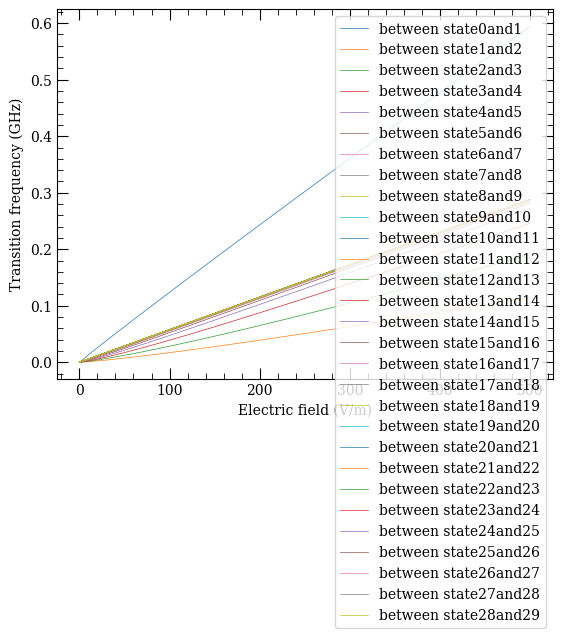

In [18]:
# Plot the transition frequency
for n in range(29):
    plt.plot(eFieldList,transitionFrequencies[n],label = 'between state'+str(n)+'and'+str(n+1), linewidth=0.5)
plt.xlabel('Electric field (V/m)')
plt.ylabel('Transition frequency (GHz)')
plt.legend()
plt.show()


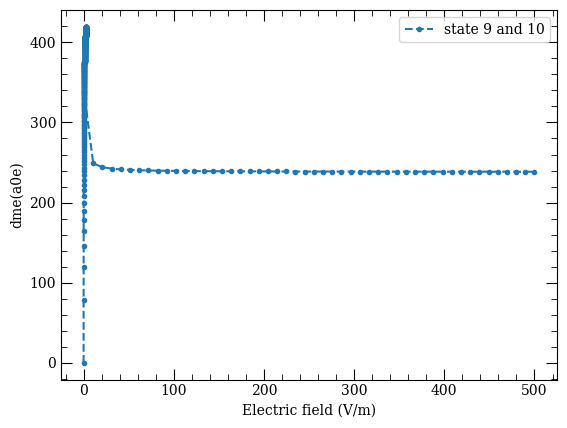

In [11]:
# Plot the dipole matrix elements
for n in range(9,10):
    plt.plot(eFieldList,dipoleMatrixElements[n],".--",label = f'state {n} and {n+1}')
plt.xlabel('Electric field (V/m)')
plt.ylabel('dme(a0e)')
plt.legend()
plt.show()


In [73]:
# Calculate the Rabi frequency
E0 = 10 # electric field in V/m
rabiFrequencies = E0*dipoleMatrixElements/hbar*a0*e*(1e-9) # in GHz

In [15]:
# Calculate the Rabi frequency
E0 = 10 # electric field in V/m
rabiFrequencies = E0*dipoleMatrixElements/hbar*a0*e*(1e-9) # in GHz


NameError: name 'rabiFrequencies' is not defined

## Create a matrix of the Hamiltonian in the basis of the |n,l,mj> states

In [14]:
atom = Rubidium()
di = n0-1 # dimension of the Hamiltonian matrix
Er = 230 # The electric field at resonance in V/m

# resonance laser energy in GHz
laserEnergy = np.interp(Er, eFieldList, energyShifts[1])-\
np.interp(Er, eFieldList, energyShifts[0])


hamiltonian_matrix = np.zeros((di,di),dtype = complex)
energys = [[] for i in range(di)]
    
# Diagonal elements are energy shifts

for m in range(len(eFieldList)):

    diagonals = [(energyShifts[n][m]-energyShifts[0][m]-laserEnergy) for n in range(di)]
    for i in range(di):
        hamiltonian_matrix[i,i] = diagonals[i]
        hamiltonian_matrix[0,0] = 0
    
        if i < di-1:
            hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0.5*rabiFrequencies[i][m]
            #hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0
            

        # Diagonalise the Hamiltonian matrix
        w, v = eig(hamiltonian_matrix)
        w_sorted_indices = np.argsort(w)
        energys[i].append(w[w_sorted_indices[i]])
    
    


ValueError: fp and xp are not of the same length.

In [77]:
# save the data
np.savez('data/no_interaction30.npz', eFieldList, energys, 
            eFieldList=eFieldList, energys = energys)

In [78]:
# load the data
fileName = 'data/no_interaction30.npz'
eFieldList0 = np.load(fileName)['eFieldList']
energys0 = np.load(fileName)['energys']

c:\Users\Chen\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


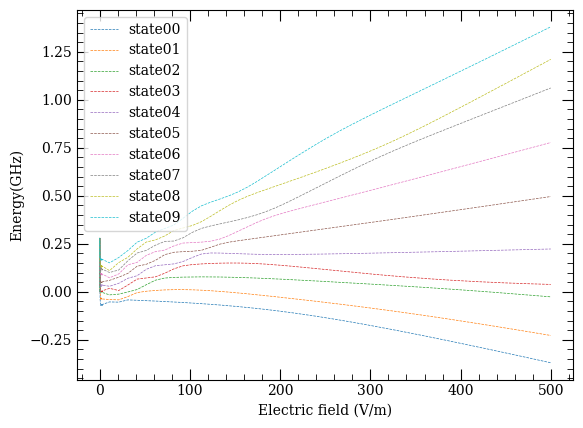

In [79]:
fig=plt.figure()
ax = fig.add_subplot(111)
r = 10
for n in range(r):
    plt.plot(eFieldList,energys[n],label = 'state'+str(n))
    #plt.plot(eFieldList,energys0[n],"--",label = 'state0'+str(n), linewidth=0.5)

plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy(GHz)')
plt.legend()
plt.show()